In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" an

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn.functional as F

from datasets import load_dataset
from torch.nn import CrossEntropyLoss, KLDivLoss, CosineEmbeddingLoss
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/CS4782FinalProject/Daniel"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = load_dataset("imdb")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

split_dataset = tokenized["train"].train_test_split(test_size=0.1, seed=42)

train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]
test_dataset = tokenized["test"]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
teacher = AutoModelForSequenceClassification.from_pretrained(
    "textattack/bert-base-uncased-imdb"
).to(device).eval()

student = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device).train()

def copy_every_other_layer(student, teacher):
    """
    Copy every other teacher layer into the student.
    Assumes student has half as many encoder layers as teacher.
    """
    teacher_layers = teacher.bert.encoder.layer
    student_layers = student.distilbert.transformer.layer

    # Copy every other teacher layer into student
    for i, layer in enumerate(student_layers):
        teacher_layer = teacher_layers[i * 2]
        layer.load_state_dict(teacher_layer.state_dict(), strict=False)

copy_every_other_layer(student, teacher)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def distillation_loss(
    student_logits,
    teacher_logits,
    student_hidden_states,
    teacher_hidden_states,
    labels,
    temperature=1.0,
    alpha=1.0,
    beta=1.0,
    gamma=1.0
):
    """
    Combines CE loss, KL-divergence loss, and cosine hidden state loss.

    student_logits: Logits from the student model (B x num_classes)
    teacher_logits: Logits from the teacher model (B x num_classes)
    student_hidden_states: List of student hidden states (len = num_student_layers + 1)
    teacher_hidden_states: List of teacher hidden states (len = num_teacher_layers + 1)
    labels: Ground-truth labels (B)

    Returns:
        total_loss: Combined loss value
        losses: Dictionary of loss components
    """

    ce_loss_fn = CrossEntropyLoss()
    kl_loss_fn = KLDivLoss(reduction="batchmean")
    cosine_loss_fn = CosineEmbeddingLoss()

    # Cross-entropy loss between student prediction and true labels
    ce_loss = ce_loss_fn(student_logits, labels)

    # KL-divergence between softened teacher and student logits
    # (B, SEQ_LEN, VOCAB_SIZE)
    # Perform sotmax over dim=-1 so that we are doing it over VOCAB_SIZE
    # dimension giving us a probability distribution for all vocabulary
    # token for each token in our batch (B x SEQ_LEN)
    t_probs = F.softmax(teacher_logits / temperature, dim=-1)
    s_logp = F.log_softmax(student_logits / temperature, dim=-1)
    kd_loss = kl_loss_fn(s_logp, t_probs) * (temperature ** 2)

    # Cosine embedding loss between intermediate hidden states
    losses = []
    teacher_layers = teacher_hidden_states[1::2]  # take every 2nd layer starting from index 1
    student_layers = student_hidden_states[1:]    # skip the student input embedding layer

    for t, s in zip(teacher_layers, student_layers):
        # Flatten hidden state in vectors of HIDDEN_STATE_SIZE for every token
        # in the batch (B, SEQ_LEN, HIDDEN_STATE_SIZE) -> (B x SEQ_LEN, HIDDEN_STATE_SIZE)
        t_flat = t.reshape(-1, t.size(-1))
        s_flat = s.reshape(-1, s.size(-1))

        # Create a tensor of ones (B x SEQ_LEN) as the target cosine similarity
        # between teacher and student hidden states
        target = torch.ones(t_flat.size(0)).to(t.device)
        losses.append(cosine_loss_fn(s_flat, t_flat, target))

    cos_loss = torch.stack(losses).mean()

    # Total weighted loss
    total_loss = alpha * ce_loss + beta * kd_loss + gamma * cos_loss

    return total_loss, {
        "ce_loss": ce_loss.item(),
        "kd_loss": kd_loss.item(),
        "cos_loss": cos_loss.item()
    }

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

train_losses = []
eval_accuracies = []
epochs_times = []

start_time = time.time()

for epoch in range(epochs):
    student.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Teacher outputs
        with torch.no_grad():
            teacher_outputs = teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            teacher_logits = teacher_outputs.logits
            teacher_hidden_states = teacher_outputs.hidden_states

        # Student outputs
        student_outputs = student(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        student_logits = student_outputs.logits
        student_hidden_states = student_outputs.hidden_states

        # Compute distillation loss (returns total_loss, loss_dict)
        loss, loss_dict = distillation_loss(
            student_logits, teacher_logits,
            student_hidden_states, teacher_hidden_states,
            labels, temperature=2.0, alpha=0.5, beta=0.5, gamma=1.0
        )

        # Update model
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    # Track training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation evaluation
    student.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["input_ids"].to(device)
            masks = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = student(inputs, attention_mask=masks)
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    eval_accuracies.append(accuracy)

    # Track time
    epoch_time = time.time() - start_time
    epochs_times.append(epoch_time)

    # Print metrics
    print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}, Acc={accuracy:.4f}, Time={epoch_time:.2f}s")

    # Reset timer for next epoch
    start_time = time.time()

Epoch 1: 100%|██████████| 1407/1407 [12:54<00:00,  1.82it/s]


Epoch 1: Loss=0.8084, Acc=0.9012, Time=790.97s


Epoch 2: 100%|██████████| 1407/1407 [12:53<00:00,  1.82it/s]


Epoch 2: Loss=0.5132, Acc=0.9080, Time=789.85s


Epoch 3: 100%|██████████| 1407/1407 [12:55<00:00,  1.81it/s]


Epoch 3: Loss=0.3805, Acc=0.9040, Time=791.77s


In [ ]:
save_model_folder_name = "dab463_distilled_student_model_imdb"
model_path = os.path.join(save_path, save_model_folder_name)

student.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Hugging Face model saved to {model_path}")

# Save a training checkpoint (for resuming training later)
def save_checkpoint(model, optimizer, epoch, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"Checkpoint saved to {path}")

checkpoint_path = os.path.join(save_path, "checkpoint.pth")
save_checkpoint(student, optimizer, epoch=epoch, path=checkpoint_path)

Hugging Face model saved to /content/drive/MyDrive/CS4782FinalProject/dab463_distilled_student_model_imdb
Checkpoint saved to /content/drive/MyDrive/CS4782FinalProject/dab463_distilled_student_model_imdb/checkpoint.pth


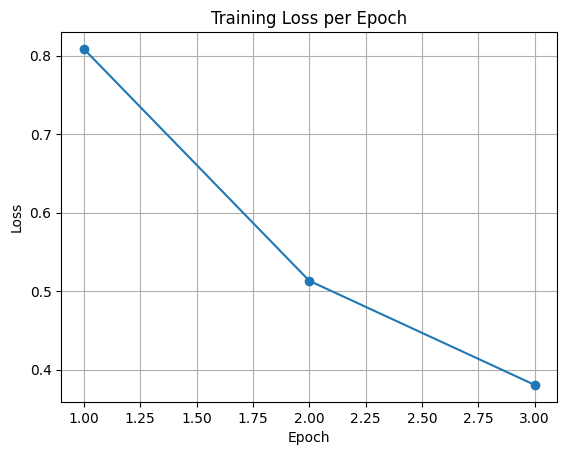

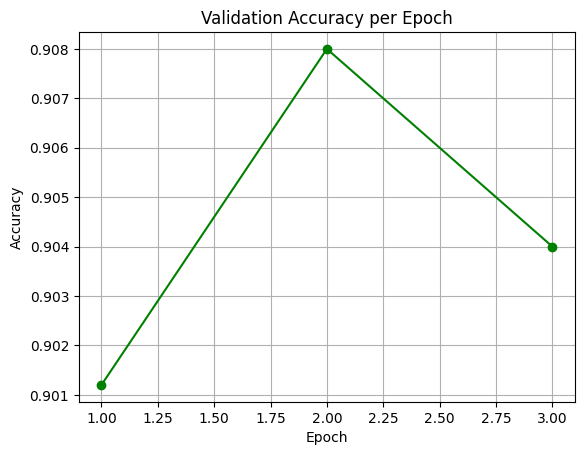

In [ ]:
# Loss curve
loss_path = os.path.join(save_path, "loss_curve.png")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig(loss_path)
plt.show()

# Accuracy curve
accuracy_path = os.path.join(save_path, "accuracy_curve.png")

plt.figure()
plt.plot(range(1, epochs+1), eval_accuracies, marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig(accuracy_path)
plt.show()

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

test_loader = DataLoader(test_dataset, batch_size=32)

student_accuracy = evaluate(student, test_loader, device)
teacher_accuracy = evaluate(teacher, test_loader, device)

retained_pct = 100 * student_accuracy / teacher_accuracy

print(f"Teacher Accuracy: {teacher_accuracy:.4f}")
print(f"Student Accuracy: {student_accuracy:.4f}")
print(f"Student retained {retained_pct:.2f}% of teacher's performance.")

Teacher Accuracy: 0.9192
Student Accuracy: 0.9062
Student retained 98.58% of teacher's performance.


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

teacher_params = count_parameters(teacher)
student_params = count_parameters(student)
compression_ratio = teacher_params / student_params

print(f"Teacher Params: {teacher_params:,}")
print(f"Student Params: {student_params:,}")
print(f"Compression Ratio: {compression_ratio:.2f}x")

Teacher Params: 109,483,778
Student Params: 66,955,010
Compression Ratio: 1.64x


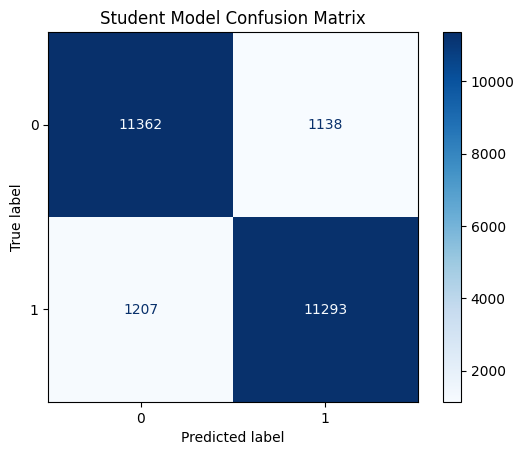

Classification Report:

              precision    recall  f1-score   support

           0     0.9040    0.9090    0.9065     12500
           1     0.9085    0.9034    0.9059     12500

    accuracy                         0.9062     25000
   macro avg     0.9062    0.9062    0.9062     25000
weighted avg     0.9062    0.9062    0.9062     25000



In [ ]:
def compute_confusion_and_report(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    report = classification_report(all_labels, all_preds, digits=4)

    return cm, report

student_cm, student_report = compute_confusion_and_report(student, test_loader, device)

cm_matrix_path = os.path.join(save_path, "confusion_matrix.png")
disp = ConfusionMatrixDisplay(confusion_matrix=student_cm)
disp.plot(cmap="Blues")
plt.title("Student Model Confusion Matrix")
plt.savefig(cm_matrix_path)
plt.show()

print("Classification Report:\n")
print(student_report)

classification_report_path = os.path.join(save_path, "classification_report.txt")
with open(classification_report_path, "w") as f:
    f.write(student_report)

In [ ]:
def benchmark_inference(model, dataloader, device, n_batches=10):
    model.eval()
    times = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= n_batches:
                break

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            start = time.time()
            _ = model(input_ids, attention_mask=attention_mask)
            end = time.time()

            times.append(end - start)

    avg_inference_time = sum(times) / len(times)
    return avg_inference_time

student_inference_time = benchmark_inference(student, test_loader, device)
teacher_inference_time = benchmark_inference(teacher, test_loader, device)

print(f"Student Avg Inference Time: {student_inference_time*1000:.2f} ms")
print(f"Teacher Avg Inference Time: {teacher_inference_time*1000:.2f} ms")
print(f"Speedup: {teacher_inference_time / student_inference_time:.2f}x faster")

Student Avg Inference Time: 5.73 ms
Teacher Avg Inference Time: 9.87 ms
Speedup: 1.72x faster


In [ ]:
metrics = {
    # Training curves
    "train_losses": train_losses,           # List: Loss per epoch
    "eval_accuracies": eval_accuracies,      # List: Validation accuracy per epoch
    "epoch_times": epochs_times,             # List: Time per epoch

    # Final evaluation results
    "student_accuracy": student_accuracy,   # Float
    "teacher_accuracy": teacher_accuracy,   # Float
    "retained_percent": retained_pct,        # Float %

    # Model sizes
    "student_num_params": student_params,    # Int
    "teacher_num_params": teacher_params,    # Int
    "compression_ratio": compression_ratio, # Float

    # Inference speed
    "student_inference_time_ms": student_inference_time * 1000,   # ms
    "teacher_inference_time_ms": teacher_inference_time * 1000,   # ms
    "inference_speedup": teacher_inference_time / student_inference_time,  # Float x faster
}

training_metrics_path = os.path.join(save_path, "training_metrics.json")
with open(training_metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

TODOs: Tune hyperparameters on the loss, train more epochs, ablation